In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [2]:
# import warnings
# warnings.filterwarnings("default")

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]=="Inh"]

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2487: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.



In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 8471 cells


In [9]:
new_sub_annotation = []
for c in obj.obs["Cell sub annotation"].tolist():
    if c in ['Inh_1', 'Inh_2', 'Inh_3', 'Inh_4', 'Inh_5', 'Inh_6']:
        new_sub_annotation.append('Inh')
    elif c in ['Inh_Meis2_1', 'Inh_Meis2_2', 'Inh_Meis2_3', 'Inh_Meis2_4']:
        new_sub_annotation.append('Inh_Meis2')
    else:
        new_sub_annotation.append(c)
obj.obs["Cell sub annotation"] = new_sub_annotation
obj.obs["Cell sub annotation"] = obj.obs["Cell sub annotation"].astype("category")

Trying to set attribute `.obs` of view, copying.


#### Data preparation

In [10]:
sf.data_preparation(obj)

#### Data split

In [11]:
s = time.time()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
data = obj.X.copy()

myDict = {}
for idx, c in enumerate(obj.obs["Cell sub annotation"].cat.categories):
    myDict[c] = idx

labels = []
for l in obj.obs["Cell sub annotation"].tolist():
    labels.append(myDict[l])

labels = np.array(labels)

X = data
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### scGeneFit

In [14]:
from scGeneFit.functions import *

In [15]:
markers = get_markers(X_train, y_train, num_markers=30, method="centers", epsilon=1.0, redundancy=0.25)

Solving a linear program with 31053 variables and 11 constraints
Time elapsed: 40397.68224668503 seconds


In [16]:
genes = obj.var.index.tolist()

selectedGenes = [genes[m] for m in markers]

selectedGenes_dict = {}
selectedGenes_dict["group"] = selectedGenes

In [17]:
e = time.time()

#### Classifiers

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2487: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.



<Figure size 432x288 with 0 Axes>

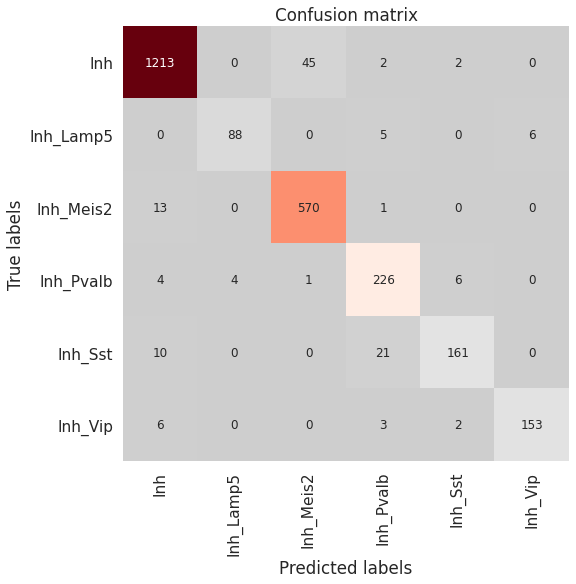

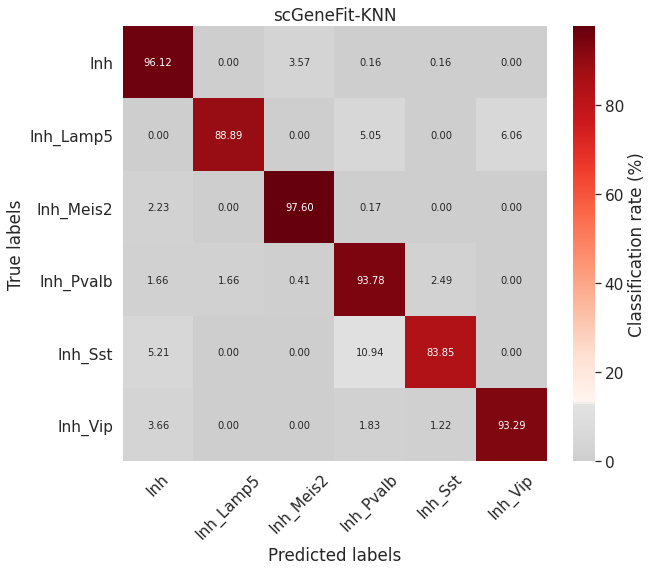

Accuracy: 0.9484657749803305: Misclassification: 0.05153422501966953
              precision    recall  f1-score   support

         Inh       0.97      0.96      0.97      1262
   Inh_Lamp5       0.96      0.89      0.92        99
   Inh_Meis2       0.93      0.98      0.95       584
   Inh_Pvalb       0.88      0.94      0.91       241
     Inh_Sst       0.94      0.84      0.89       192
     Inh_Vip       0.96      0.93      0.95       164

    accuracy                           0.95      2542
   macro avg       0.94      0.92      0.93      2542
weighted avg       0.95      0.95      0.95      2542



In [18]:
sf.run_classifiers(obj, group_by="Cell sub annotation", genes=selectedGenes, classifier="KNN", balance=True, title="scGeneFit-KNN")

#### Heatmap selected genes

In [19]:
dict_ens_id = {}
for k, j in zip(obj.var.index.tolist(), obj.var['SYMBOL'].tolist()):
    dict_ens_id[k] = j
    
selectedGenes_t = []
for g in selectedGenes:
    selectedGenes_t.append(dict_ens_id[g])
    
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

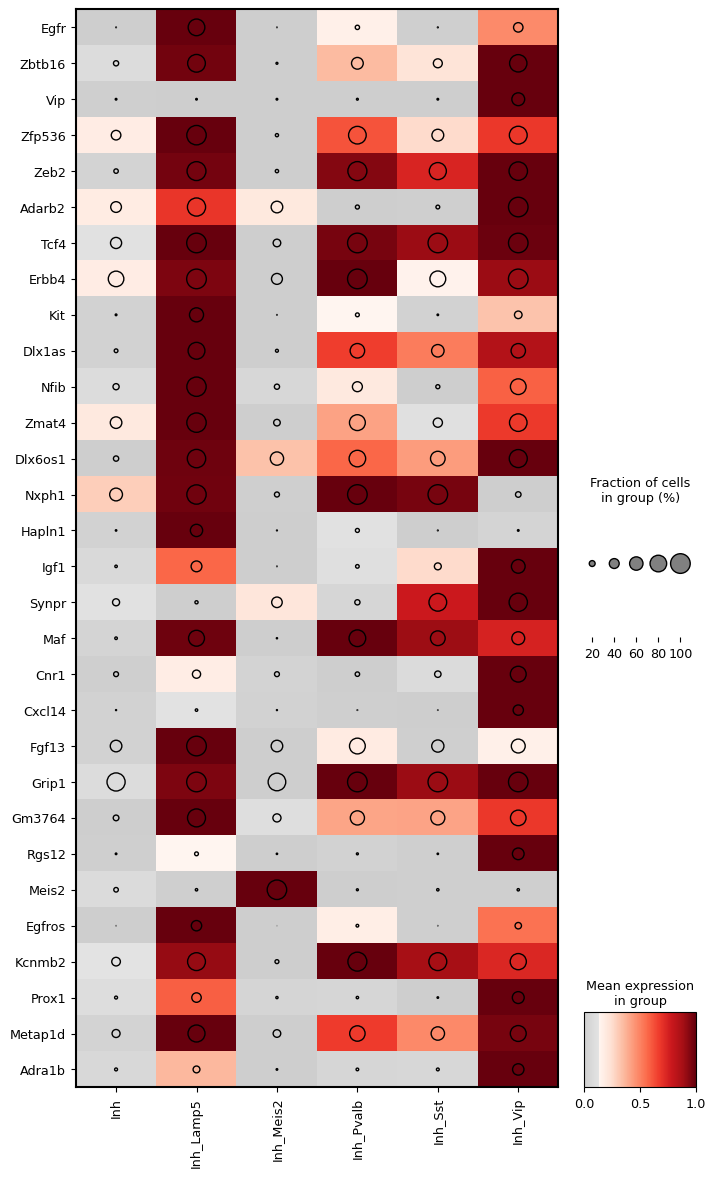

In [20]:
matplotlib.rcdefaults()
matplotlib.rcParams.update({'font.size': 11})
ax = sc.pl.DotPlot(obj,
                   selectedGenes_t,
                   gene_symbols = "SYMBOL",
                   groupby="Cell sub annotation",
                   standard_scale='var',
                   use_raw=True,
                   figsize=(8,14),
                   linewidths=2).style(cmap=mymap, color_on='square', grid=True, dot_edge_lw=1)
ax.swap_axes(swap_axes=True)
# ax.show()

ax.savefig("Figures/scGeneFit_top30.pdf")

# Elapsed time

In [21]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 8471 cells


In [22]:
print('Elapsed time (s): ', e-s)

Elapsed time (s):  40399.16166353226
